# Saudi Used Cars Project

This is the third capstone project of the Bootcamp Data Science and Machine Learning at DTI Purwadhika. The goal of the project is to predict the price of a used car based on its features.



# Business Problem Understanding

## Context
A dataset of used cars in Saudi Arabia with various features like make, model, year, mileage, and price. The goal is to analyze the factors affecting car prices and build a model to predict used car prices accurately, helping both buyers and sellers make informed decisions in the used car market.

## Problem Statement
The used car market faces several challenges:
1. Price uncertainty leads to inefficient negotiations and potential financial losses
2. Many factors influence car prices (age, mileage, brand, etc.), making manual estimation difficult
3. Market participants lack reliable tools to validate car valuations
4. Time and resources are wasted in price negotiations due to information asymmetry

## Goals
1. Develop an accurate price prediction model to:
   - Help sellers set competitive yet fair prices
   - Help buyers evaluate if asking prices are reasonable
   - Reduce negotiation time and friction in transactions
2. Identify key factors that influence used car prices in Saudi Arabia
3. Compare different machine learning approaches to find the most reliable prediction method

## Analytic Approach
1. Data Analysis:
   - Analyze relationships between features and price
   - Identify patterns and trends in the market
   - Handle missing values and outliers appropriately

2. Model Development:
   We'll test multiple regression models:
   - Linear Regression (baseline model)
   - Ridge
   - Lasso
   - Random Forest Regressor
   - XGBoost Regressor
   - LightGBM Regressor
   
3. Model Comparison:
   - Compare models using multiple metrics
   - Analyze trade-offs between complexity and accuracy
   - Select the best model based on performance and practicality

## Metric Evaluation
We'll use multiple metrics to ensure robust model evaluation:

Primary Metrics:
- R² Score: To measure the model's explanatory power
- RMSE (Root Mean Square Error): To measure prediction accuracy in actual price terms
- MAE (Mean Absolute Error): To measure average prediction error

Secondary Considerations:
- Model training time
- Prediction speed
- Model interpretability
- Feature importance analysis

The final model selection will balance prediction accuracy with practical considerations like computation speed and interpretability.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
warnings.filterwarnings('ignore')

## Data Loading and Initial Exploration

In [33]:
# 1. Data Loading and Initial Exploration
df = pd.read_csv('data/data_saudi_used_cars.csv')

# Basic data exploration
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
display(df.describe(include='all'))


Dataset Shape: (5624, 11)

Missing Values:
 Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
count,5624,5624,5624,5624,5624,5624,5624.000000,5624.000000,5.624000e+03,5624,5624.000000
unique,347,27,58,2,4,3,NaN,NaN,NaN,2,NaN
top,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full,NaN,NaN,NaN,False,NaN
freq,269,2272,1431,4875,4188,2233,NaN,NaN,NaN,3828,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2014.101885,3.295430,1.509234e+05,NaN,53074.058144
std,NaN,NaN,NaN,NaN,NaN,NaN,5.791606,1.515108,3.828360e+05,NaN,70155.340614
min,NaN,NaN,NaN,NaN,NaN,NaN,1963.000000,1.000000,1.000000e+02,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,2.000000,3.800000e+04,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,3.000000,1.030000e+05,NaN,36500.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,4.500000,1.960000e+05,NaN,72932.500000


#### Drop duplicates

In [34]:
display("Duplicated rows:", df.duplicated().sum())

df = df.drop_duplicates()

display("Duplicated rows now:", df.duplicated().sum())

'Duplicated rows:'

4

'Duplicated rows now:'

0

### Cars with price = 0


We have around 1797 cars with price = 0. Since this is not valid price, as far as modelling is concerned, these prices will make the model biased, and the data will be skewed for price prediction model.

Let's see the distribution of the cars with price = 0.


In [35]:
display(df[df['Price'] == 0].describe(include='all'))

# Calculate percentage of negotiable prices
negotiable_pct = (df['Negotiable'].sum() / len(df)) * 100
print(f"\nPercentage of negotiable prices in original dataset: {negotiable_pct:.2f}%")

df_zero_price = df[df['Price'] == 0]
df = df[df['Price'] != 0]

display(df_zero_price['Negotiable'].value_counts())


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
count,1796,1796,1796,1796,1796,1796,1796.000000,1796.000000,1.796000e+03,1796,1796.0
unique,221,27,43,2,4,3,NaN,NaN,NaN,2,NaN
top,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full,NaN,NaN,NaN,True,NaN
freq,121,655,541,1451,1291,759,NaN,NaN,NaN,1795,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2012.501670,3.541537,1.685968e+05,NaN,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,6.757189,1.601942,3.920362e+05,NaN,0.0
min,NaN,NaN,NaN,NaN,NaN,NaN,1965.000000,1.000000,1.000000e+02,NaN,0.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,2010.000000,2.400000,1.575000e+04,NaN,0.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,2014.000000,3.500000,1.000000e+05,NaN,0.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,2017.000000,4.600000,2.220000e+05,NaN,0.0



Percentage of negotiable prices in original dataset: 31.94%


Negotiable
True     1795
False       1
Name: count, dtype: int64

As you can see, almost all of the cars with price = 0 are negotiable. It does not introduce variability in the data, i.e. not a good predictor. Thus, we'll drop these rows for now.


### Add car age


Adding car age column to give better correlation between car age and price.

In [36]:
current_year = 2024
df['Car_Age'] = current_year - df['Year']

df

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price,Car_Age
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000,10
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000,9
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000,9
5,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000,5
6,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000,12
...,...,...,...,...,...,...,...,...,...,...,...,...
5616,CX9,Qassim,Mazda,Automatic,Saudi,Full,2020,2.0,9500,False,132000,4
5618,Suburban,Riyadh,GMC,Automatic,Saudi,Full,2006,5.3,86000,False,50000,18
5619,X-Trail,Jeddah,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,False,68000,6
5621,Yukon,Dammam,GMC,Automatic,Saudi,Full,2016,5.3,48000,False,145000,8


## Numerical Features Correlation

In [37]:
original_numerical_features = ['Mileage', 'Engine_Size', 'Car_Age', 'Price']

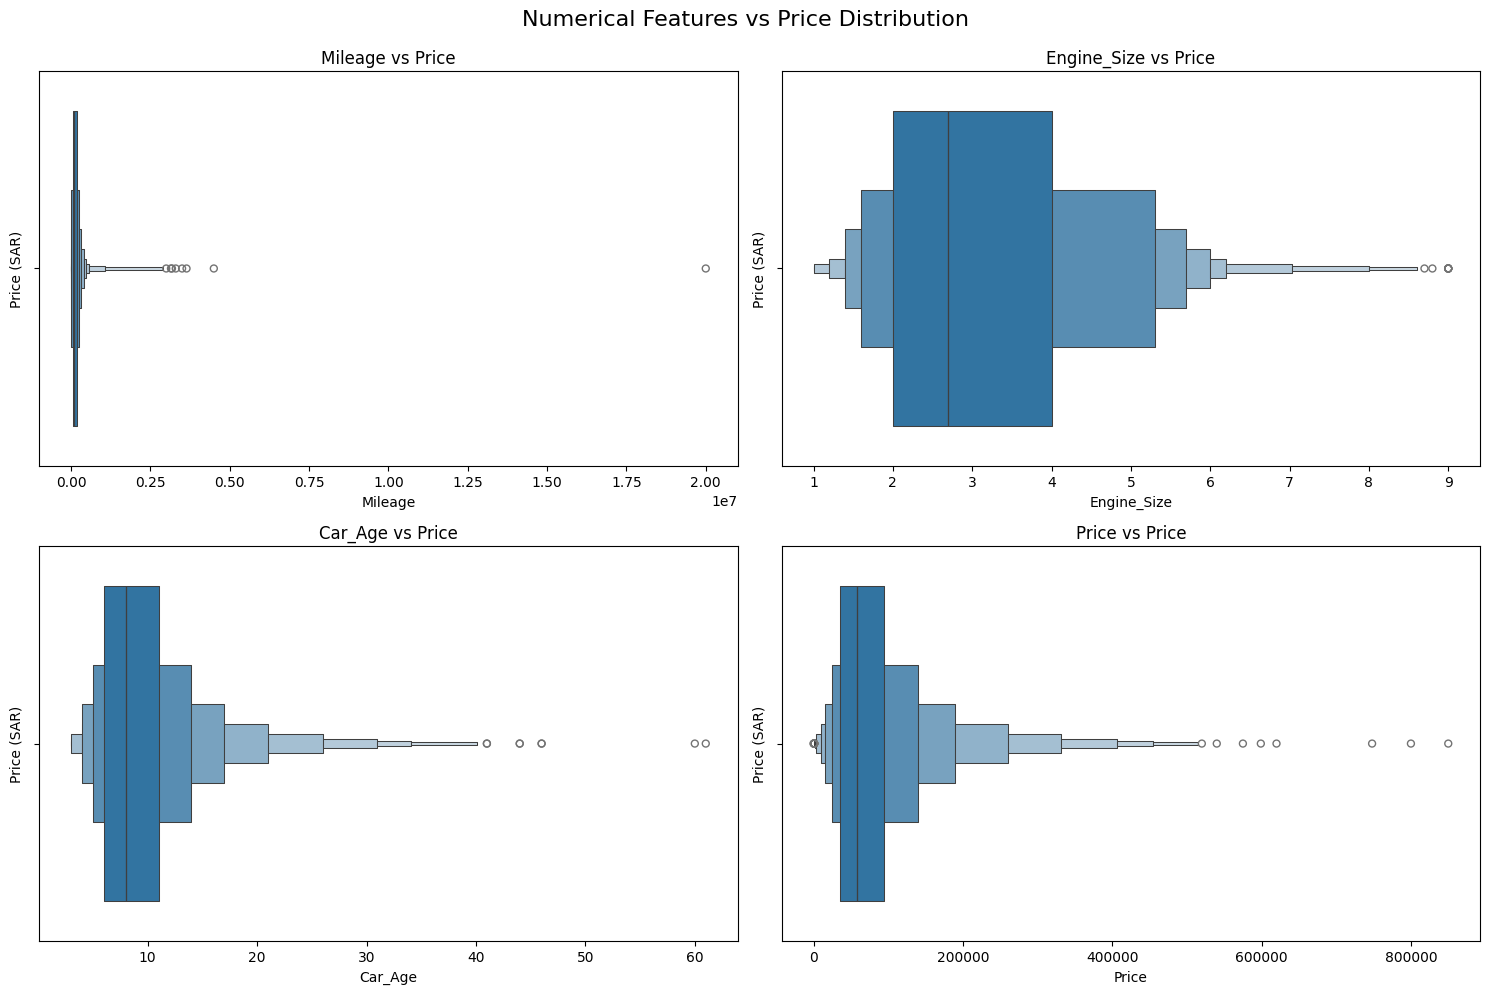

In [38]:
# create boxplot for numerical features
fig, axes = plt.subplots(2, 2, figsize=(15,  10))
fig.suptitle('Numerical Features vs Price Distribution', fontsize=16, y=0.99)

for idx, feature in enumerate(original_numerical_features):
    row = idx // 2
    col = idx % 2

    sns.boxenplot(data=df, x=feature, ax=axes[row, col])
    
    axes[row, col].set_title(f'{feature} vs Price')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Price (SAR)')

plt.tight_layout()
plt.show()


There is strange outlier in `Mileage`, the values seems odd `20.000.000` if we compare to other high mileage cars.

Let's drop this row for now, as it's too high even compared to other high mileage cars.


In [39]:
df = df[df['Mileage'] < 20000000]
df[df['Mileage'] > 1000000].sort_values(by='Mileage', ascending=False)


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price,Car_Age
572,Camry,Yanbu,Toyota,Automatic,Other,Full,1998,2.5,4500000,False,15000,26
4193,Innova,Riyadh,Toyota,Manual,Saudi,Standard,2013,2.7,3640000,False,30000,11
1412,Trailblazer,Jeddah,Chevrolet,Automatic,Other,Full,2004,5.3,3500000,False,10000,20
4548,Tahoe,Riyadh,Chevrolet,Automatic,Saudi,Semi Full,2008,5.7,3300000,False,27000,16
915,Pathfinder,Riyadh,Nissan,Automatic,Saudi,Standard,1998,3.5,3180003,False,10500,26
4875,Pathfinder,Riyadh,Nissan,Automatic,Saudi,Full,2008,2.6,3150000,False,20000,16
3387,Fusion,Hail,Ford,Automatic,Saudi,Full,2010,2.5,3000000,False,17000,14
1334,Prado,Makkah,Toyota,Manual,Saudi,Semi Full,2006,4.0,2800000,False,35000,18
3797,Marquis,Riyadh,Ford,Automatic,Saudi,Semi Full,2005,4.6,2500000,False,9000,19
333,Range Rover,Jeddah,Land Rover,Automatic,Saudi,Full,2009,2.4,2013000,False,35000,15


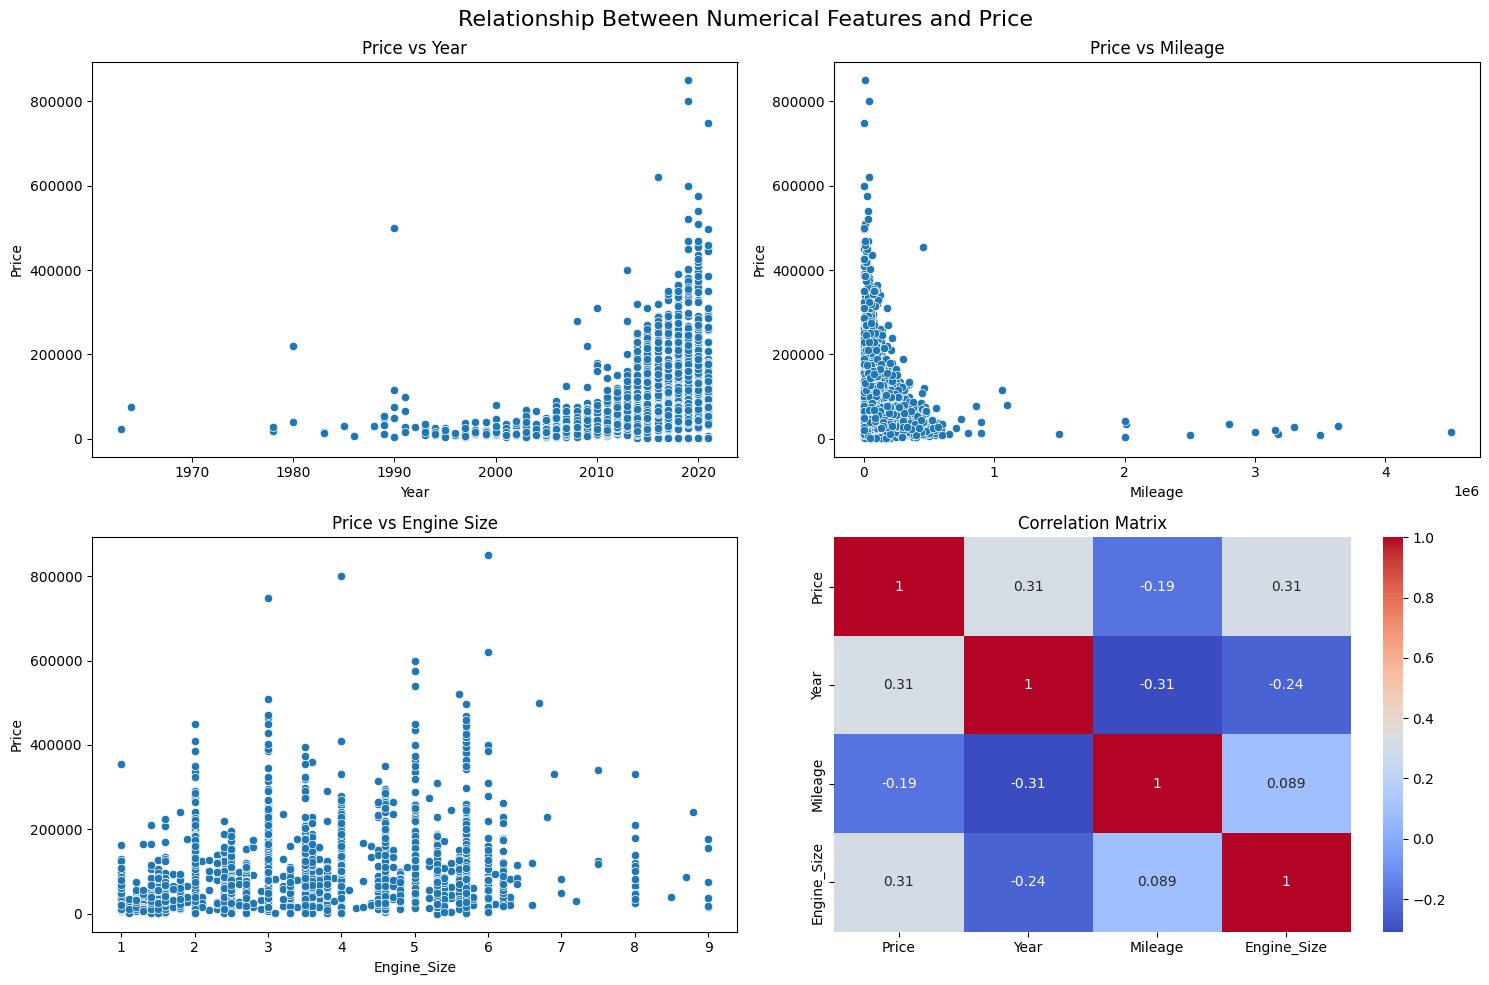


Correlation with Price:
Year: 0.314
Mileage: -0.190
Engine_Size: 0.308


In [40]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Relationship Between Numerical Features and Price', fontsize=16)

# Plot Price vs Year
sns.scatterplot(data=df[df['Price'] > 0], x='Year', y='Price', ax=axes[0,0])
axes[0,0].set_title('Price vs Year')

# Plot Price vs Mileage
sns.scatterplot(data=df[df['Price'] > 0], x='Mileage', y='Price', ax=axes[0,1])
axes[0,1].set_title('Price vs Mileage')

# Plot Price vs Engine_Size
sns.scatterplot(data=df[df['Price'] > 0], x='Engine_Size', y='Price', ax=axes[1,0])
axes[1,0].set_title('Price vs Engine Size')

# Calculate correlation
correlation_matrix = df[['Price', 'Year', 'Mileage', 'Engine_Size']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

# Print correlation values with Price
print("\nCorrelation with Price:")
for col in ['Year', 'Mileage', 'Engine_Size']:
    correlation = df[col].corr(df['Price'])
    print(f"{col}: {correlation:.3f}")

### Result

1. `Year vs Price`
    - Moderately positive correlation (0.31)
    - Almost linear with significant outliers (old cars and high price luxury cars)

2. `Mileage vs Price`
    - Negative weak correlation (-0.19)
    - Non linear

3. `Engine_Size vs Price`
    - Positive correlation (0.31)
    - Non linear correlation

Since both linear and non-linear correlation is present, we'll keep all of them, and to *assess* which model is the most suitable, together with categorical features.


## Categorical Features Correlation

Let's see the distribution of the price by each categorical feature.

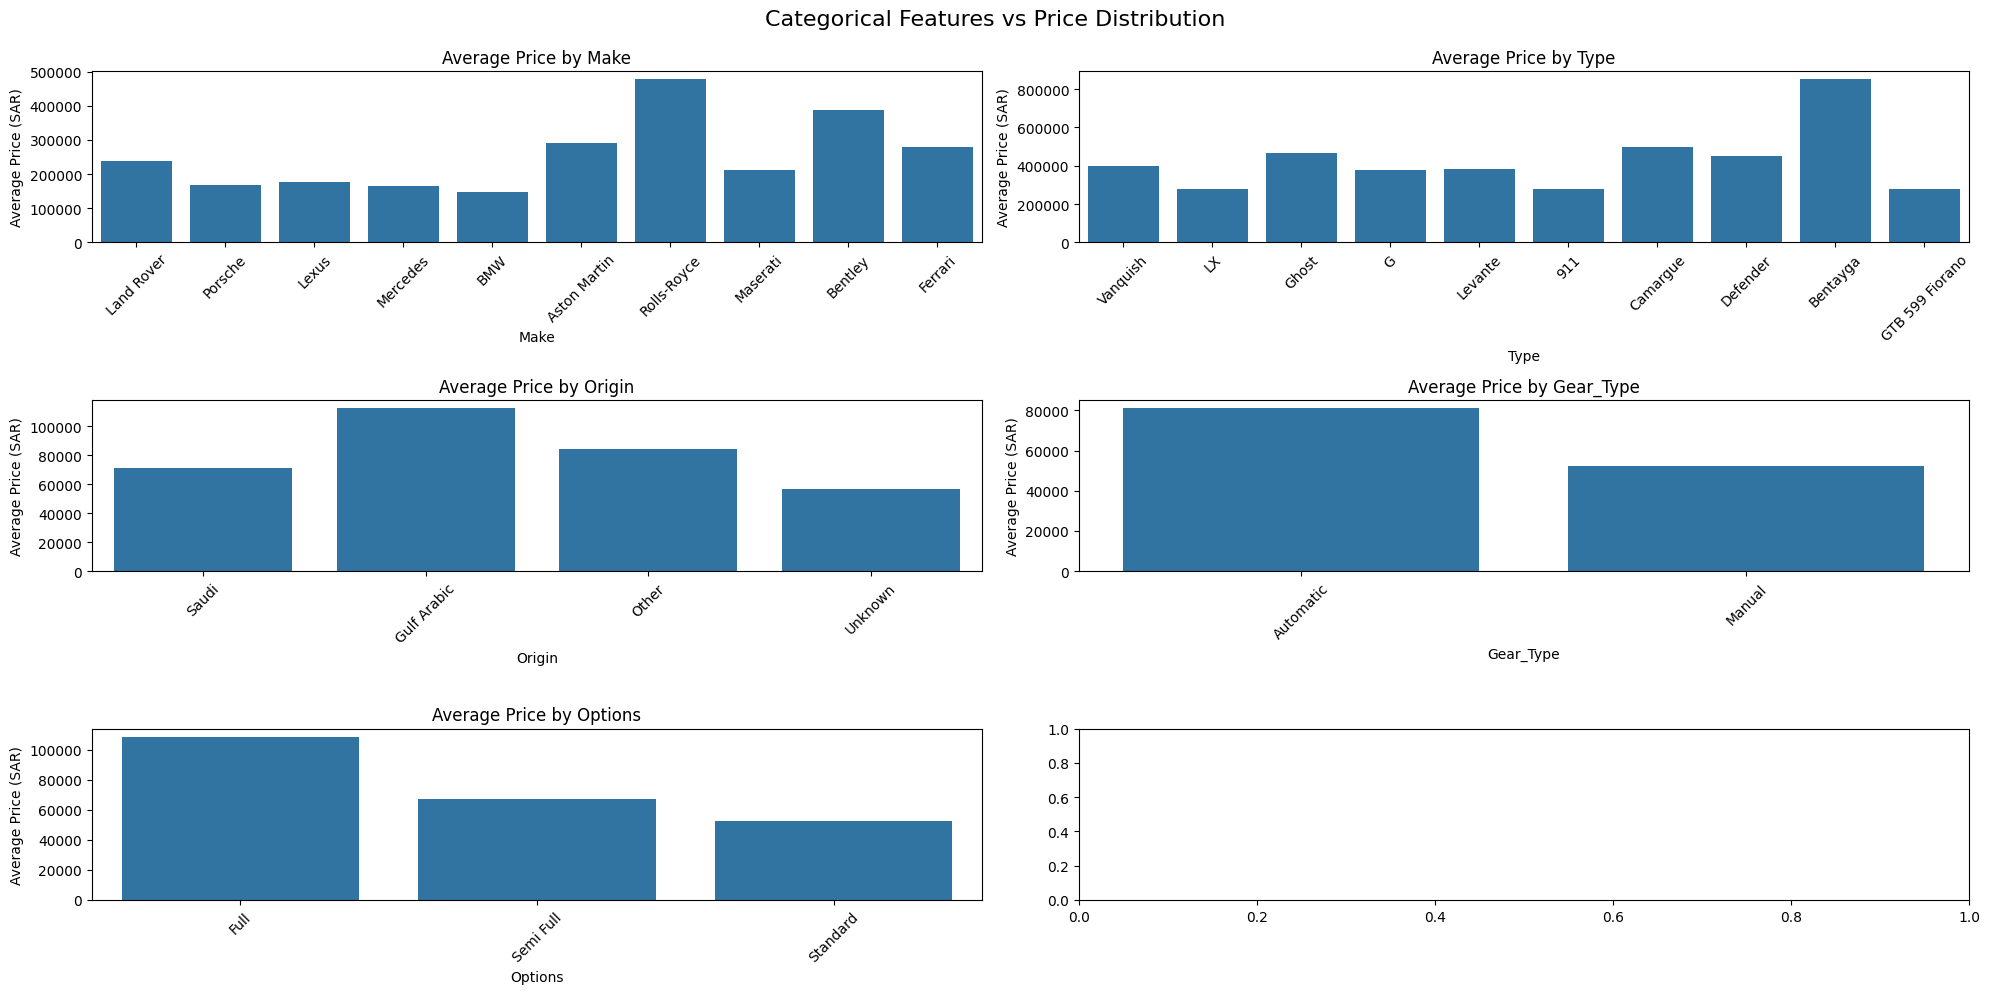

In [41]:
# Create visualization for categorical features vs price
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
fig.suptitle('Categorical Features vs Price Distribution', fontsize=16, y=0.99)

# Select top 4 categorical features based on their correlation
important_cats = ['Make', 'Type', 'Origin', 'Gear_Type', 'Options']

for idx, feature in enumerate(important_cats):
    row = idx // 2
    col = idx % 2
    
    if not (row == 3 and col == 1):
        # Calculate mean price for each category
        mean_prices = df.groupby(feature)['Price'].mean().sort_values(ascending=False).head(10)
        
        # Create bar plot
        sns.barplot(data=df[df[feature].isin(mean_prices.index)], 
                    x=feature, y='Price',
                    ax=axes[row, col],
                    errorbar=None)  # Disable confidence intervals for cleaner look
        
        axes[row, col].set_title(f'Average Price by {feature}')
        axes[row, col].tick_params(axis='x', rotation=45)
        axes[row, col].set_ylabel('Average Price (SAR)')

plt.tight_layout()
plt.show()


### Boxplot distribution of price by each categorical feature

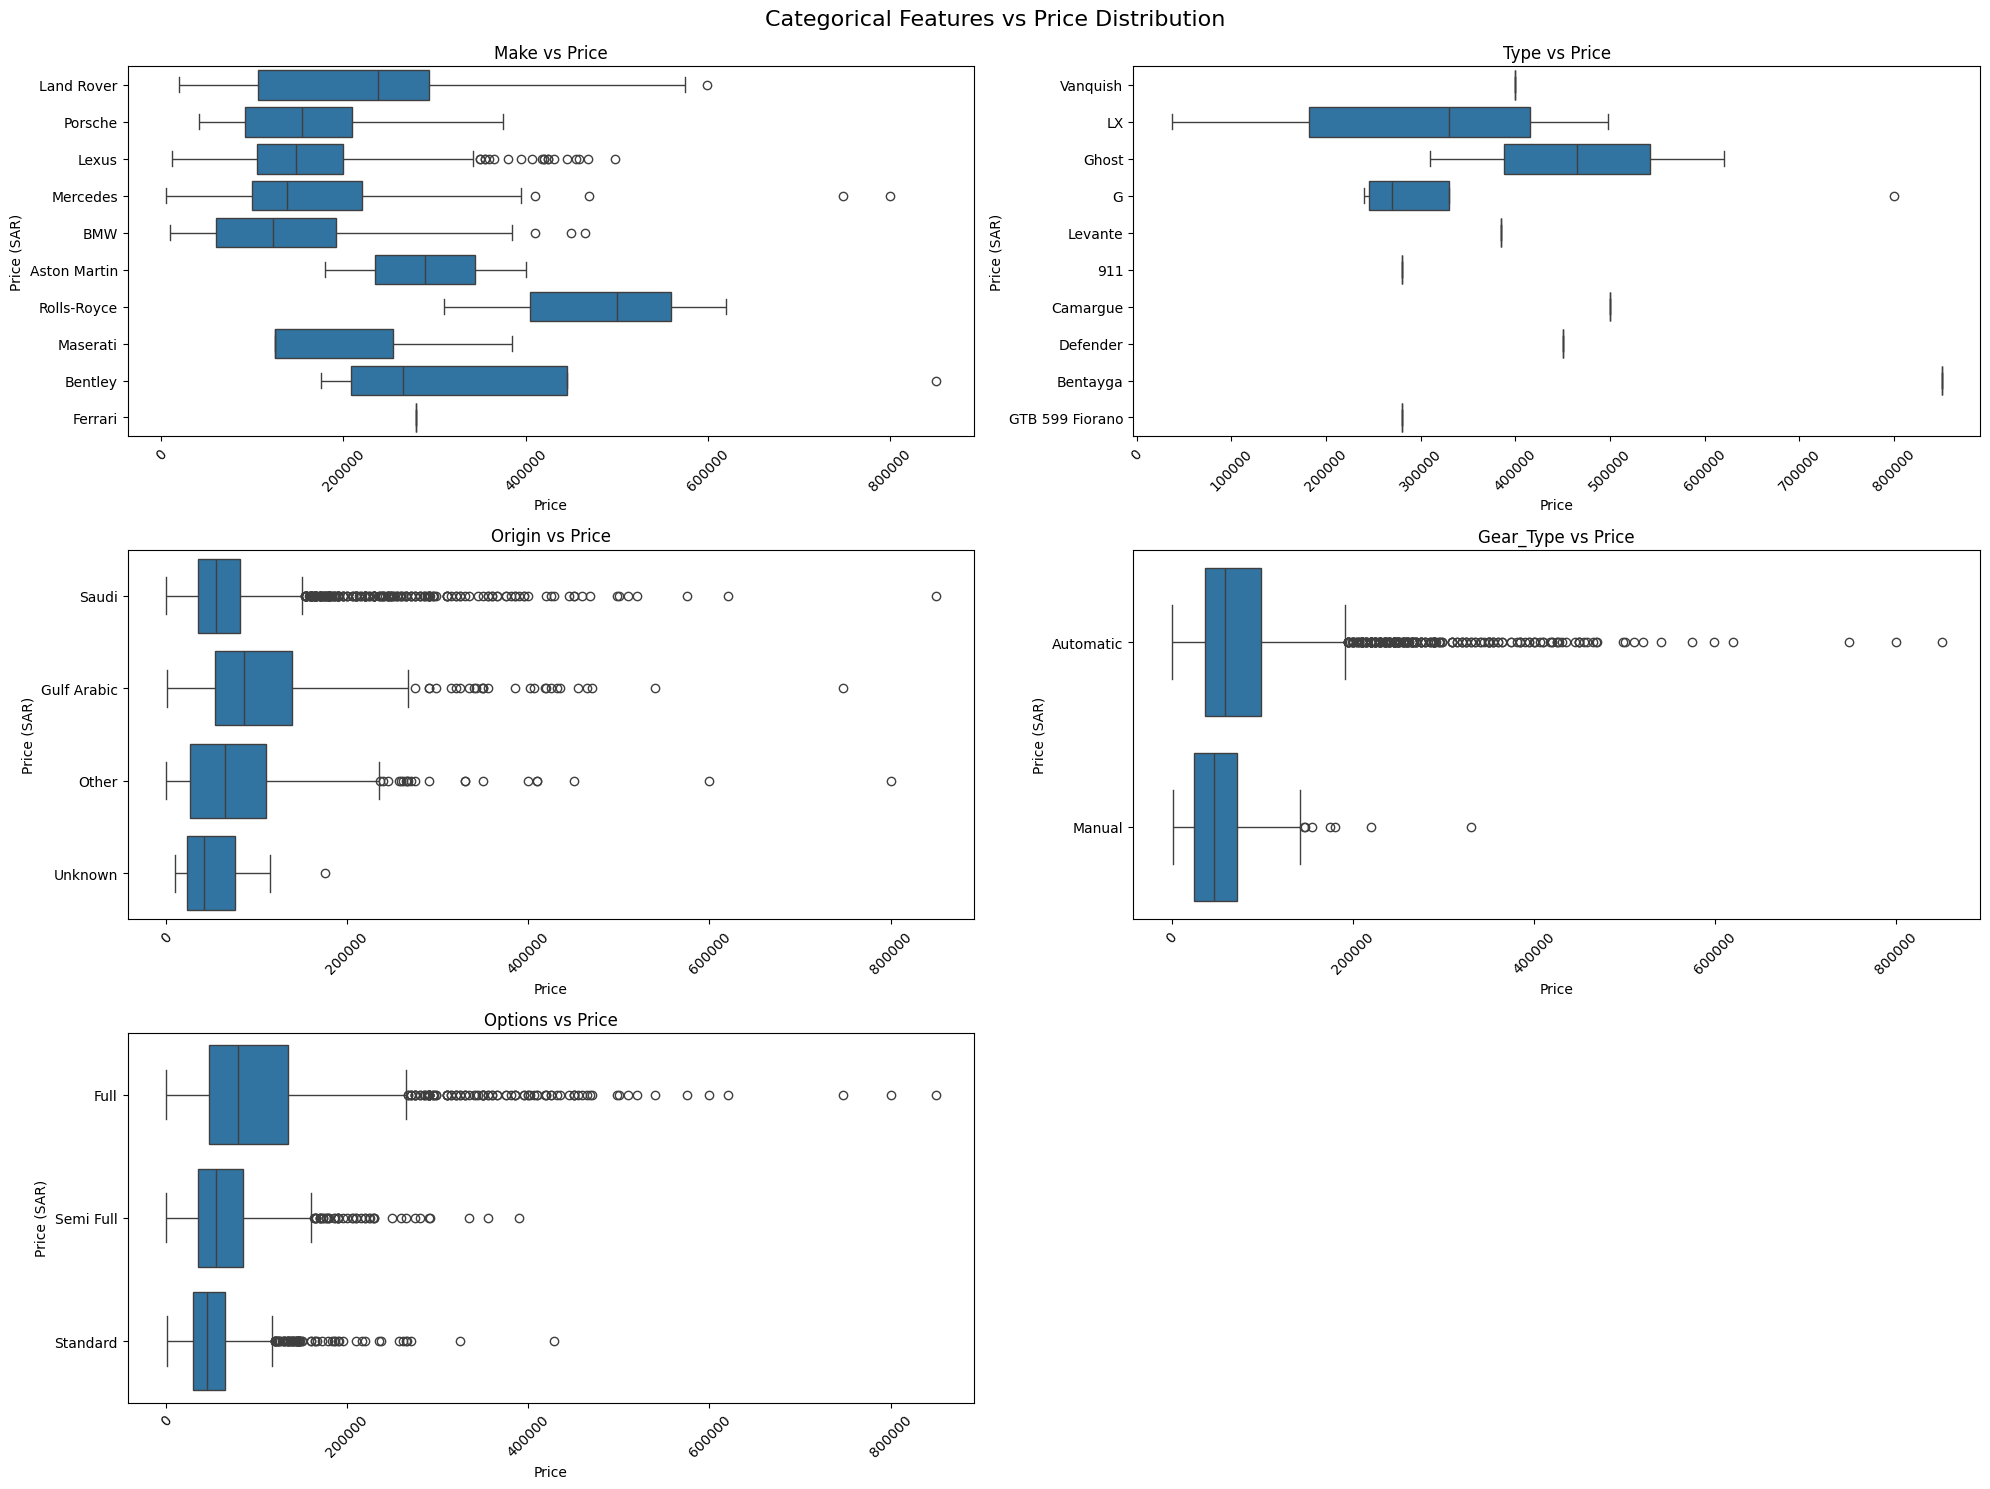

In [42]:
# Create boxplot for categorical features vs price
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Categorical Features vs Price Distribution', fontsize=16, y=0.99)

# Select top 4 categorical features based on their correlation
important_cats = ['Make', 'Type', 'Origin', 'Gear_Type', 'Options']

for idx, feature in enumerate(important_cats):
    row = idx // 2
    col = idx % 2
    
    if not (row == 2 and col == 1):
        # Calculate mean price for each category
        mean_prices = df.groupby(feature)['Price'].mean().sort_values(ascending=False).head(10)
        
        # Create bar plot
        sns.boxplot(data=df[df[feature].isin(mean_prices.index)], 
                    x='Price', y=feature,
                    ax=axes[row, col])
        
        axes[row, col].set_title(f'{feature} vs Price')
        axes[row, col].tick_params(axis='x', rotation=45)
        axes[row, col].set_ylabel('Price (SAR)')

axes[2, 1].set_visible(False)
plt.tight_layout()
plt.show()

## Data preprocessing

### Encode categorical variables

In [43]:
display(df)

df_encoded = df.copy()

# Handle categorical variables
categorical_features = ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']
label_encoders = {}

for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    df_encoded[feature] = label_encoders[feature].fit_transform(df[feature])

# Feature engineering
# Add car age
current_year = 2024
df_encoded['Car_Age'] = current_year - df_encoded['Year']

df_encoded

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price,Car_Age
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000,10
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000,9
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000,9
5,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000,5
6,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000,12
...,...,...,...,...,...,...,...,...,...,...,...,...
5616,CX9,Qassim,Mazda,Automatic,Saudi,Full,2020,2.0,9500,False,132000,4
5618,Suburban,Riyadh,GMC,Automatic,Saudi,Full,2006,5.3,86000,False,50000,18
5619,X-Trail,Jeddah,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,False,68000,6
5621,Yukon,Dammam,GMC,Automatic,Saudi,Full,2016,5.3,48000,False,145000,8


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price,Car_Age
1,314,20,19,0,2,0,2014,8.0,80000,False,120000,10
2,241,20,33,0,0,0,2015,5.0,140000,False,260000,9
3,211,10,32,0,2,1,2015,2.4,220000,False,42000,9
5,59,0,40,0,2,1,2019,2.0,25000,False,58000,5
6,73,20,47,0,2,0,2012,4.8,189000,False,85000,12
...,...,...,...,...,...,...,...,...,...,...,...,...
5616,62,18,40,0,2,0,2020,2.0,9500,False,132000,4
5618,270,20,19,0,2,0,2006,5.3,86000,False,50000,18
5619,307,13,44,0,2,2,2018,2.5,78794,False,68000,6
5621,314,9,19,0,2,0,2016,5.3,48000,False,145000,8


## Model Development

We will test and evaluate 6 models to predict the price of the car:
- Linear Regression
- Ridge
- Lasso
- Random Forest
- XGBoost
- LightGBM


In [47]:
# Prepare features and target
X = df_encoded.drop(['Price'], axis=1)
y = df_encoded['Price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Create and evaluate models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42)
}

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model and measure time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    return {
        'R2 Score': r2,
        'RMSE': rmse,
        'MAE': mae,
        'CV R2 Mean': cv_scores.mean(),
        'CV R2 Std': cv_scores.std(),
        'Training Time': training_time
    }

# Evaluate all models
results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    results[name] = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)

# Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

# Display results
print("\nModel Comparison:")
display(results_df)


Evaluating Linear Regression...

Evaluating Ridge...

Evaluating Lasso...

Evaluating Random Forest...

Evaluating XGBoost...

Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 3058, number of used features: 10
[LightGBM] [Info] Start training from score 77575.232832
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 2446, number of used features: 10
[LightGBM] [Info] Start training from score 76593.015536
[LightGBM] [Info] Auto-choosing r

,R2 Score,RMSE,MAE,CV R2 Mean,CV R2 Std,Training Time
Linear Regression,0.3982,61046.7754,35090.7858,0.3406,0.0258,0.0013
Ridge,0.3982,61048.0407,35089.6525,0.3403,0.0263,0.0005
Lasso,0.3982,61047.0272,35090.3268,0.3403,0.0263,0.0008
Random Forest,0.8044,34800.7521,17002.7903,0.7482,0.0473,0.7162
XGBoost,0.8262,32804.0233,15965.3550,0.7641,0.0399,0.1776
LightGBM,0.8365,31816.6477,16041.1046,0.7642,0.0476,0.5348


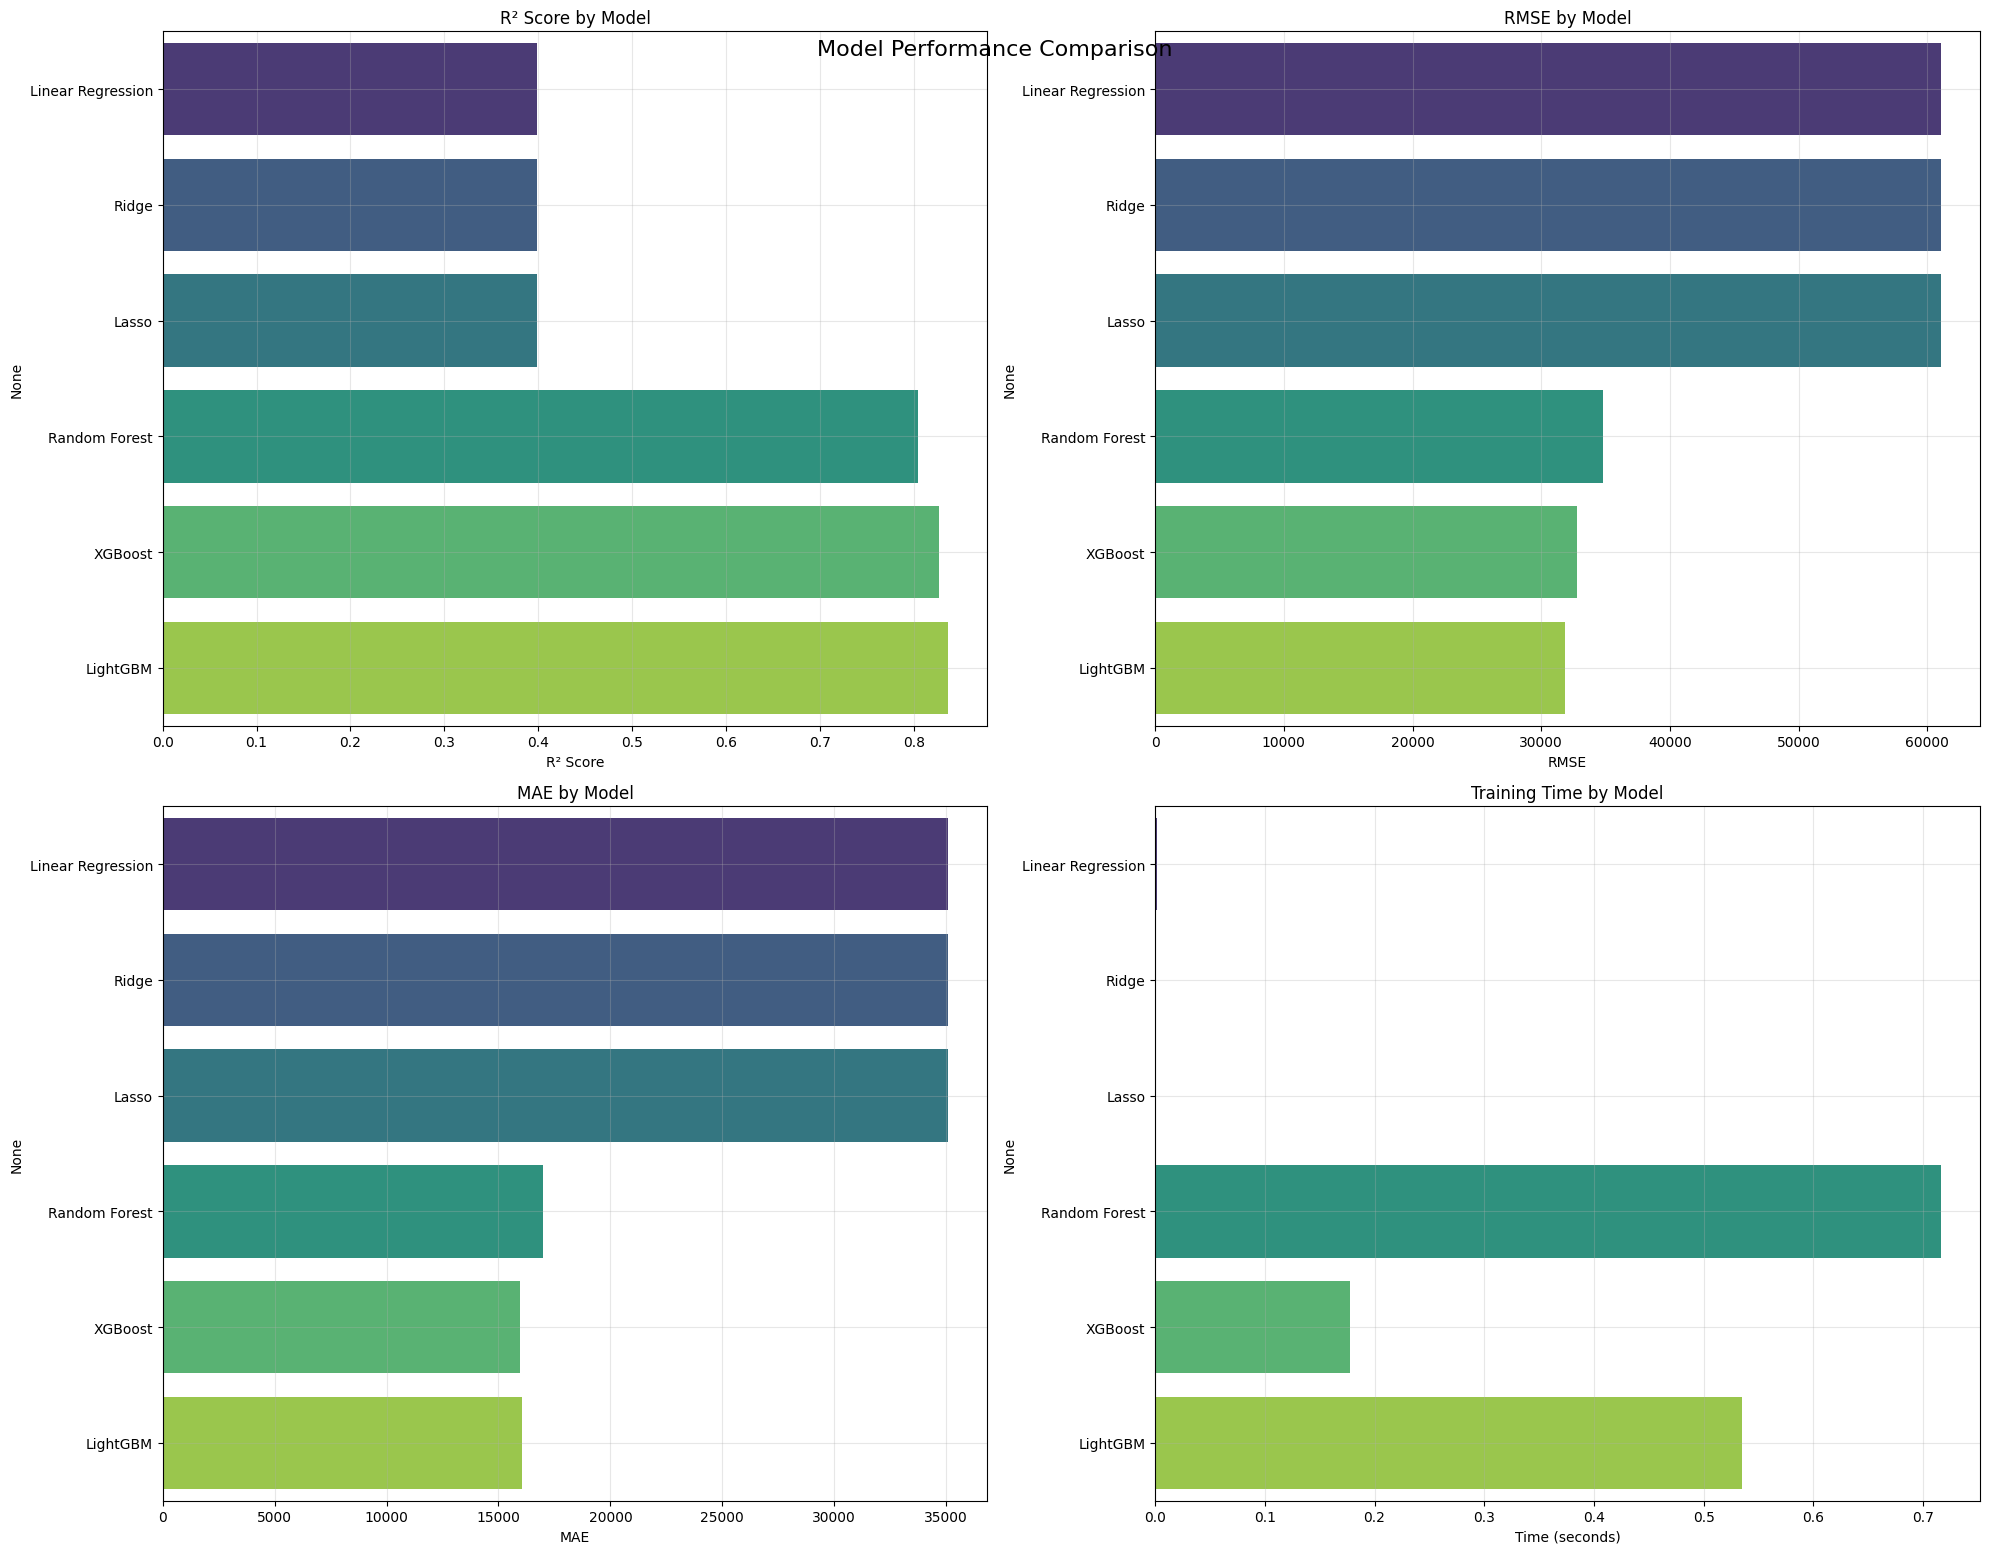

In [48]:
# Convert the results to a more seaborn-friendly format
results_melted = results_df.reset_index()
results_melted = results_melted.melt(id_vars=['index'], var_name='Metric', value_name='Value')
results_melted = results_melted.rename(columns={'index': 'Model'})

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Model Performance Comparison', fontsize=16, y=0.95)

# Plot R2 Score
sns.barplot(data=results_df, y=results_df.index, x='R2 Score', 
            ax=axes[0,0], palette='viridis')
axes[0,0].set_title('R² Score by Model')
axes[0,0].set_xlabel('R² Score')
axes[0,0].grid(True, alpha=0.3)

# Plot RMSE
sns.barplot(data=results_df, y=results_df.index, x='RMSE', 
            ax=axes[0,1], palette='viridis')
axes[0,1].set_title('RMSE by Model')
axes[0,1].set_xlabel('RMSE')
axes[0,1].grid(True, alpha=0.3)

# Plot MAE
sns.barplot(data=results_df, y=results_df.index, x='MAE', 
            ax=axes[1,0], palette='viridis')
axes[1,0].set_title('MAE by Model')
axes[1,0].set_xlabel('MAE')
axes[1,0].grid(True, alpha=0.3)

# Plot Training Time
sns.barplot(data=results_df, y=results_df.index, x='Training Time', 
            ax=axes[1,1], palette='viridis')
axes[1,1].set_title('Training Time by Model')
axes[1,1].set_xlabel('Time (seconds)')
axes[1,1].grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

## Results

From the results, we can see that the `LightGBM` model has the best performance:
1. Highest R² score -> means it explains the variance of the price the highest, i.e. 83%
2. Lowest RMSE (lower is better)
3. Lowest MAE (lower is better)

However, the `LightGBM` model has the longest training time compared to other models.

Given the trade-off between model complexity and performance, for production, we'll choose the `XGBoost` model, since it has a good balance between performance and training time.

As for our analysis, we'll choose the `LightGBM` model, since it has the best performance.